# Exploration of performance data of AutoBooch kombucha brewing system

In [2]:
import time
import pandas as pd
import matplotlib.pyplot as plt

Import data from the log file:

In [2]:
boochData = pd.read_csv("brew_log.txt", sep=" ", header=0)

Make sure it's OK (well, enough for jazz):

In [3]:
boochData.head()

,time,temp,state
0,1.521122e+09,24.312,OFF
1,1.521124e+09,24.250,OFF
2,1.521126e+09,24.437,OFF
3,1.521128e+09,24.562,OFF
4,1.521130e+09,24.500,OFF


Are there outliers? (of course there are)

In [4]:
boochData.max()

time     1.52301e+09
temp              85
state             ON
dtype: object

In [5]:
boochData.min()

time     1.52112e+09
temp          17.437
state            OFF
dtype: object

Let's have a quick look at the data (and set the axes and fonts):

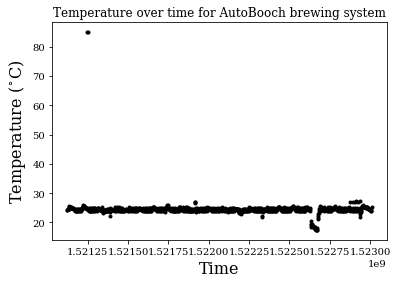

In [13]:
plt.rcParams["font.family"] = "serif"
plt.plot(boochData["time"], boochData["temp"],'.k')
plt.title(r'Temperature over time for AutoBooch brewing system')
plt.xlabel("Time", fontsize=16)
plt.ylabel(r'Temperature ($^{\circ}$C)', fontsize=16)
plt.show()

So we can see how far the outliers are out. 

The lonesome, very high, temperature (85°C) must have been from me leaving the sensor in the sun while changing a batch. Similarly, the low temperatures (down to 17°C) would have been where I left it exposed to the cool air for an hour or so. 

Also note the strange time axis—the default for the time modules is 'seconds since Unix epoch (January 1, 1970)'!

We're concerned here with the operating performance, so we can safely filter the outliers. Let's also look at how much time the data spans:

In [87]:
time.ctime(boochData["time"].min())

'Thu Mar 15 09:00:02 2018'

In [88]:
time.ctime(boochData["time"].max())

'Fri Apr  6 05:00:02 2018'

So the data was only taken for three weeks, in early Spring (Northern Hemisphere). So we don't need to account for seasonal variation. Let's just look at the daily variation:

Define a function to get the hour of the day. This uses the funny syntax from the time module.

In [7]:
def t2hours(t):
    """Return the hour of the day from a time.time structure. Also convert from UTC to my time-zone (US Central, UTC-5)"""
    return (float(time.gmtime(t).tm_hour) + float(time.gmtime(t).tm_min)/60.0 - 5.0) % 24

In [8]:
boochData['hours'] = boochData.apply(lambda row: t2hours(row["time"]), axis=1)

All right, we're ready for a closer look, doc!

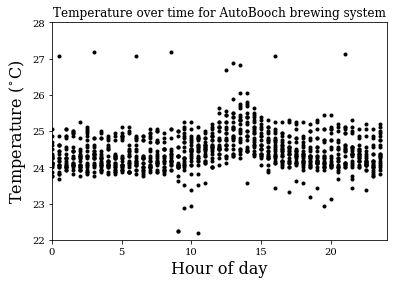

In [9]:
plt.plot(boochData["hours"], boochData["temp"],'.k')
plt.title(r'Temperature over time for AutoBooch brewing system')                                                                                                                        
plt.xlabel("Hour of day", fontsize=16)                                                                                                                                                         
plt.ylabel(r'Temperature ($^{\circ}$C)', fontsize=16)
plt.ylim( 22, 28 )
plt.xlim( 0, 24 )
plt.show()

Note that there are many points for each time of day, but they each have a similar spread (it's almost like we constrained the range ;) ). We're interested in the general performance trend. We'll need to make a tool for that:

In [137]:
import numpy as np
def rngAvg(x, y):
    return np.average(y[(y["hours"]==x)]["temp"])

In [11]:
t = np.arange(0, 24, 0.5, dtype="float")
y = [rngAvg(x,boochData[(boochData["temp"]<30) & (boochData["temp"]>22)]) for x in t]

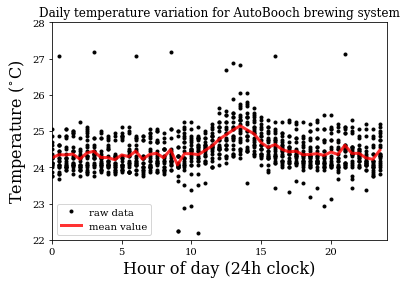

In [12]:
plt.plot(boochData["hours"], boochData["temp"],'.k',label="raw data")
plt.plot(t,y,'-r',linewidth=3,alpha=0.8,label="mean value")
plt.title(r'Daily temperature variation for AutoBooch brewing system')                                                                                                                        
plt.xlabel("Hour of day (24h clock)", fontsize=16)                                                                                                                                                         
plt.ylabel(r'Temperature ($^{\circ}$C)', fontsize=16)
plt.ylim( 22, 28 )
plt.xlim( 0, 24 )
plt.legend()
plt.show()

So you can see the temperature tends to peak around 2pm and is a minimum during the night. Note that this data set is for a little less than a month (right before Spring), so seasonal trends aren't as important as daily ones.

## Conclusion
The AutoBooch is performing as planned! Mean temperatures are within the defined operating range.

In [135]:
%%html
<hr>

## Update
Having run the autobooch for five months, we can get some sense of how the system performs with seasonality.

In [156]:
boochData_update = pd.read_csv("brew_log_updated.txt", sep=" ", header=0)
boochData_update['date'] = pd.to_datetime(boochData_update['time'], unit='s')

In [157]:
boochData_update.describe()

,time,temp
count,6.623000e+03,6623.000000
mean,1.527083e+09,25.409283
std,3.442415e+06,4.930490
min,1.521122e+09,17.437000
25%,1.524102e+09,24.375000
50%,1.527084e+09,24.812000
75%,1.530064e+09,25.500000
max,1.533044e+09,85.000000


In [158]:
boochData_update['date'].describe()

count                           6623
unique                          6623
top       2018-03-21 18:30:02.410000
freq                               1
first     2018-03-15 14:00:02.730000
last      2018-07-31 13:30:02.290000
Name: date, dtype: object

In [159]:
boochData_update['hour'] = [(x.hour-5)%24 + (x.minute//30)/2 for x in boochData_update['date']]

In [160]:
boochData_update = \
boochData_update[(boochData_update['temp'] < 80) & (boochData_update['temp'] > 22)]

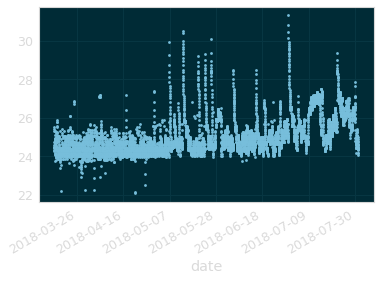

In [161]:
boochData_update.plot('date', 'temp', style='.c', legend=False, label="data")

Note the vertical temperature spikes for some days. Let's examine the temperature variation with hour of day:

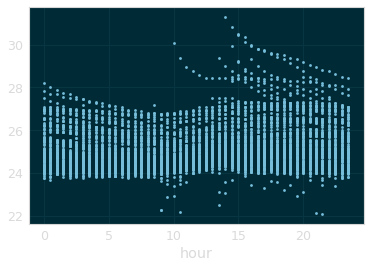

In [162]:
boochData_update.plot('hour', 'temp', style='.c', legend=False)

Note the cooling lines with a plateau. Perhaps this is a function of entering into the summer months.

In [165]:
import datetime as dt
boochData_update['before_summer'] = \
[np.where(x.date() < dt.date(2018, 6, 1), 'before summer','during summer') \
 for x in boochData_update['date']]
boochData_update['before_summer'] = [str(x) for x in boochData_update['before_summer']]
boochData_update['before_summer'] = boochData_update['before_summer'].astype('category')

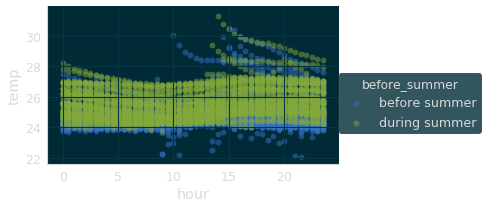

In [166]:
import seaborn as sns
import matplotlib.pyplot as plt
fg = sns.FacetGrid(data=boochData_update, hue='before_summer', aspect=1.7)
fg.map(plt.scatter, 'hour', 'temp', alpha=0.5).add_legend()

The lines we saw occur both before and during the summer months.

In [167]:
import numpy as np
def rngAvg(x, y):
    return np.average(y[(y["hour"]==x)]["temp"])

t = np.arange(0, 24, 0.5, dtype="float")
y2 = [rngAvg(x, boochData_update) for x in t]

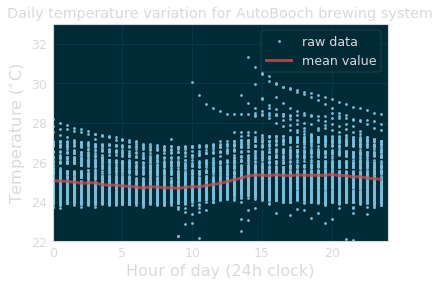

In [168]:
plt.plot(boochData_update["hour"], boochData_update["temp"], '.c',label="raw data")
plt.plot(t, y2, '-r', linewidth=3, alpha=0.8, label="mean value")
plt.title(r'Daily temperature variation for AutoBooch brewing system')                                                                                                                        
plt.xlabel("Hour of day (24h clock)", fontsize=16)                                                                                                                                                         
plt.ylabel(r'Temperature ($^{\circ}$C)', fontsize=16)
plt.ylim( 22, 33 )
plt.xlim( 0, 24 )
plt.legend()
plt.show()

This is due to the fact that we don't have an active cooling system for the autobooch (yet). Always good to leave something for future development!

In [169]:
boochData_update.dtypes

time                    float64
temp                    float64
state                    object
date             datetime64[ns]
hour                    float64
before_summer          category
dtype: object

## Conclusion, part two
After five months of continuous operation, the Autobooch is still running nominally. However, it is obvious that some active cooling would stablize the temperature further.